In [2]:
import torch
import torch.nn as nn

from torch import optim
import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torch.utils.data

import pandas as pd
import pickle
import os
from PIL import Image

from utils.tokenMaker import Lang
from utils.tool import padding, flatMutileLength, fixString
from model.BigModel import SubImgToSeq, SubToSeq
from dataset.readVideo import DramaDataset
useCuda = True
device = torch.device("cuda" if useCuda else "cpu")

In [4]:
DataDir="/home/ball/Videos/Broke"
datasets = DramaDataset(basedir=DataDir,
                        maxFrame=1,
                        timeOffset=0.2,
                        startSeries=6,
                        maxSeries=1,
                        useBmp=True,
                        randomStart=False)
transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                ])
baseDir = "others/human/"

Total Drama: 21


In [3]:
import random
def getSample(size):
    imgs = []
    pres = []
    nexs = []
    for i in range(size):
        pre, nex, img = random.choice(datasets)
        imgs.append(img)
        pres.append(pre)
        nexs.append(nex)
    return pres, nexs, imgs

In [4]:
sampleSize = 50
pres, nexs, imgs = getSample(sampleSize)
fileNames = []
for i in range(sampleSize):
    fn = "{:02d}.bmp".format(i)
    imgs[i][0].save(baseDir + fn)
    fileNames.append(fn)
data = pd.DataFrame([], columns=["Img", "Pre", "Next"])
data["Img"] = fileNames
data["Pre"] = pres
data["Next"] = nexs
data.to_json(baseDir+"sent.json")

In [28]:
data = pd.read_json(baseDir+"sent.json")

In [31]:
ModelDir = "ImgSub2Sub/models/BK_CH_RD_FIX_200"
with open(os.path.join(ModelDir, "Lang.pkl"), 'rb') as f:
    lang = pickle.load(f)
    print("Load lang model: {}. Word size: {}".format(ModelDir, len(lang)))
model = torch.load(os.path.join(ModelDir, "SubImgModel.40.pth")).to(device).eval()

def predit(model, lang, imgs, subtitle, max_length=50):
    ans = []
    probs = []
    inputImgs = imgs.unsqueeze(0).to(device)
    subtitle = torch.LongTensor(lang.sentenceToVector(subtitle, sos=False, eos=False)).unsqueeze(0).to(device)
    inputs = torch.LongTensor([[lang["SOS"]]]).long().to(device)
    
    hidden = None
    
    cxt = model.makeContext(inputImgs, subtitle)
    for i in range(max_length):
        outputs, hidden = model.decode(inputs, cxt, hidden)
        prob, outputs = outputs.topk(1)
        probs.append(prob.item())

        if(outputs.item() == lang["EOS"]):
            break
        ans.append(outputs.item())

        inputs = outputs.squeeze(1).detach()
    return lang.vectorToSentence(ans)

Load lang model: ImgSub2Sub/models/BK_CH_RD_FIX_200. Word size: 3801


In [42]:
RD_result = []
for ix, row in data.iterrows():
    img = transform(Image.open(baseDir+row["Img"])).unsqueeze(0)
    RD_result.append(predit(model, lang, img, row["Pre"]))

In [9]:
ModelDir = "ImgSub2Sub/models/BK_CH_FIX_200"
with open(os.path.join(ModelDir, "Lang.pkl"), 'rb') as f:
    lang = pickle.load(f)
    print("Load lang model: {}. Word size: {}".format(ModelDir, len(lang)))
model = torch.load(os.path.join(ModelDir, "SubImgModel.40.pth")).to(device).eval()

def predit(model, lang, imgs, subtitle, max_length=50):
    ans = []
    probs = []
    inputImgs = imgs.unsqueeze(0).to(device)
    subtitle = torch.LongTensor(lang.sentenceToVector(subtitle, sos=False, eos=False)).unsqueeze(0).to(device)
    inputs = torch.LongTensor([[lang["SOS"]]]).long().to(device)
    
    hidden = None
    
    cxt = model.makeContext(inputImgs, subtitle)
    for i in range(max_length):
        outputs, hidden = model.decode(inputs, cxt, hidden)
        prob, outputs = outputs.topk(1)
        probs.append(prob.item())

        if(outputs.item() == lang["EOS"]):
            break
        ans.append(outputs.item())

        inputs = outputs.squeeze(1).detach()
    return lang.vectorToSentence(ans)

Load lang model: ImgSub2Sub/models/BK_CH_FIX_200. Word size: 3801


In [10]:
FIXF_result = []
for ix, row in data.iterrows():
    img = transform(Image.open(baseDir+row["Img"])).unsqueeze(0)
    FIXF_result.append(predit(model, lang, img, row["Pre"]))

In [11]:
ModelFile = "SubToSub/models/BK_CH_FIX_200/"
model = torch.load(ModelFile+"SubSubModel.10.pth")
with open(ModelFile+"Lang.pkl", 'rb') as f:
    lang = pickle.load(f)
    print("Load lang model: {}. Word size: {}".format(ModelFile, len(lang)))
    
def subPredit(model, lang, in_sents, max_length=50):
    ans = []
    in_seq = torch.LongTensor(lang.sentenceToVector(in_sents, sos=False, eos=False)).unsqueeze(0).to(device)
    inputs = torch.LongTensor([[lang["SOS"]]]).to(device)
    hidden = None
    
    cxt = model.makeContext(in_seq)
    for i in range(max_length):
        outputs, hidden = model.decode(inputs, cxt, hidden)
        prob, outputs = outputs.topk(1)

        if(outputs.item() == lang["EOS"]):
            break
        ans.append(outputs.item())
        inputs = outputs.squeeze(1).detach()
    return lang.vectorToSentence(ans)

Load lang model: SubToSub/models/BK_CH_FIX_200/. Word size: 3703


In [12]:
SUB_result = []
for ix, row in data.iterrows():
    SUB_result.append(subPredit(model, lang, row["Pre"]))

In [13]:
RANDOM_result = []
for ix, row in data.iterrows():
    while True:
        nex = random.choice(data["Next"])
        if nex != row["Next"]:
            break
    RANDOM_result.append(nex)

In [43]:
data["RD_Frame"] = RD_result
data["FIX_Frame"] = FIXF_result
data["SUB_Only"] = SUB_result
data["Random"] = RANDOM_result
data = data[['Img', 'Pre', 'Next', 'RD_Frame', 'FIX_Frame', 'SUB_Only', 'Random']]
data[:2]

,Img,Pre,Next,RD_Frame,FIX_Frame,SUB_Only,Random
0,00.bmp,夠我開一家平價服飾店了,天吶,100塊錢還多,人們都沒出來美國 真是一千美元,等等 不許再嘲笑我三年前買了一半,搶劫 盜竊 持刀搶盜
1,01.bmp,又一次被當人質挾持了,就像我們的蜜月,那邊還有點吃完啊 那是貝貨啊,如果我有點緊張 只有一次,你知道嗎 我有點失控嗎,你真讓我丟臉


In [24]:
data.to_csv(baseDir+"pred.csv")
data.to_json(baseDir+"pred.json", orient='records', force_ascii=False)

In [5]:
data = pd.read_json(baseDir+"pred.json")

FIX_Frame     如果我覺得 麥克斯
Img              22.bmp
Next         她們都是來消費的顧客
Pre           我不懂這有什么問題
RD_Frame      沒問題 我不過來了
Random          那只是名字而已
SUB_Only            我沒有
Name: 15, dtype: object


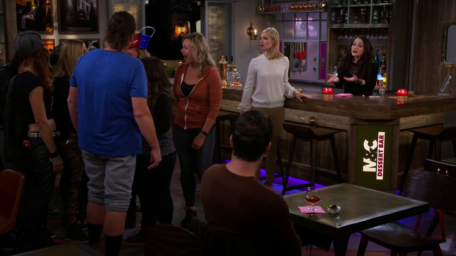

In [8]:
row = data.iloc[15]
print(row)
Image.open(baseDir+row["Img"])